In [1]:
import findspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer
from pyspark.ml.clustering import KMeans
import pyspark.sql.functions as f

In [3]:
spark = SparkSession.builder.appName('news').getOrCreate()
df = spark.read.csv('news.csv', header= True, inferSchema=True)
df.show(5)

+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|       publish_date|         description|                text|                 url|
+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  0|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|"Canadian pharmac...|"" he said.  Tadr...|
|  1|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|"The Yukon govern...|  from March 9 to 13|
|  2|['The Associated ...|U.S. Senate passe...|2020-03-26 05:13:00|The Senate has pa...|"The Senate late ...|"" said Democrati...|
|  3|        ['Cbc News']|Coronavirus: The ...|2020-03-27 00:36:00|Scientists around...|"Scientists aroun...| "" said Zarychanski|
|  4|        ['Cbc News']|The latest on the...|2020-03-26 20:57:00|The latest on th

In [4]:
df = df.select('description', 'text')
df.show(5)

+--------------------+--------------------+
|         description|                text|
+--------------------+--------------------+
|Canadian pharmaci...|"Canadian pharmac...|
|The Yukon governm...|"The Yukon govern...|
|The Senate has pa...|"The Senate late ...|
|Scientists around...|"Scientists aroun...|
|The latest on the...|"    Trudeau says...|
+--------------------+--------------------+
only showing top 5 rows



In [5]:
df.count()

3566

In [6]:
df.count() - df.distinct().count()

861

In [7]:
df = df.dropDuplicates()
df.count()

2705

In [8]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
description,0
text,0


In [9]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
description,0
text,0


##### do not have NaN, null value

In [10]:
token1 = Tokenizer(inputCol = 'description', outputCol = 'token_text1')
swremove1 = StopWordsRemover(inputCol = 'token_text1', outputCol = 'stop_tokens1')
count_vec1 = CountVectorizer(inputCol = 'stop_tokens1', outputCol = 'c_vec1')
idf1 = IDF(inputCol = 'c_vec1', outputCol = 'tf_idf1')

token2 = Tokenizer(inputCol = 'text', outputCol = 'token_text2')
swremove2 = StopWordsRemover(inputCol = 'token_text2', outputCol = 'stop_tokens2')
count_vec2 = CountVectorizer(inputCol = 'stop_tokens2', outputCol = 'c_vec2')
idf2 = IDF(inputCol = 'c_vec2', outputCol = 'tf_idf2')


In [11]:
clean = VectorAssembler(inputCols = ['tf_idf1', 'tf_idf2'], outputCol = 'features')

In [12]:
pipe = Pipeline(stages = [token1, swremove1, count_vec1, idf1, token2, swremove2, count_vec2, idf2, clean])

In [13]:
cleaner = pipe.fit(df)

In [14]:
final = cleaner.transform(df)

In [15]:
final= final.select('features')
final.show(5)

+--------------------+
|            features|
+--------------------+
|(45751,[1,24,41,7...|
|(45751,[0,15,16,9...|
|(45751,[0,51,53,7...|
|(45751,[14,31,745...|
|(45751,[0,34,54,8...|
+--------------------+
only showing top 5 rows



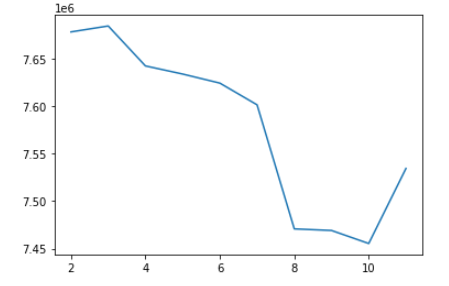

In [18]:
k_list = []
wssse_list = []
for k in range(2,12):
    kmeans = KMeans(featuresCol = 'features', k = k)
    model = kmeans.fit(final)
    wssse = model.computeCost(final)
    k_list.append(k)
    wssse_list.append(wssse)
    print('With k =', k, ', SSE =', str(wssse))
plt.plot(k_list, wssse_list)
plt.show()

##### Using Elbow Method, we choose k = 8

In [19]:
kmeans = KMeans(featuresCol = 'features', k = 8)
model = kmeans.fit(final)

In [20]:
model.computeCost(final)

7462010.821688562

In [21]:
predictions = model.transform(final)

In [22]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [23]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    2|
|         6|    1|
|         3|    1|
|         5|   16|
|         4|   53|
|         7|    1|
|         2|    1|
|         0| 2630|
+----------+-----+

